In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
plt.style.use('default')
from tqdm import tqdm

In [2]:
DATASET = 'olist_order_reviews_dataset.csv'
df = pd.read_csv(DATASET)

### Explorando e limpando Dataframe

A célula abaixo demonstra que existem order ids com mais de uma review atribuída a eles 

In [3]:
df_grpOrder = df.groupby("order_id")['review_score'].count()
df_grpOrder[df_grpOrder.values > 1]

order_id
0035246a40f520710769010f752e7507    2
013056cfe49763c6f66bda03396c5ee3    2
0176a6846bcb3b0d3aa3116a9a768597    2
02355020fd0a40a0d56df9f6ff060413    2
029863af4b968de1e5d6a82782e662f5    2
                                   ..
fd95ae805c63c534f1a64589e102225e    2
fe041ba1c9f54016432fa6ee91709dbc    2
ff763b73e473d03c321bcd5a053316e8    2
ff850ba359507b996e8b2fbb26df8d03    2
ffaabba06c9d293a3c614e0515ddbabc    2
Name: review_score, Length: 547, dtype: int64

As células abaixo demonstrma que se filtrarmos apenas para as reviews que têm títulos, grande parte dos dados é perdido

In [4]:
df.shape

(99224, 7)

In [5]:
df[df['review_comment_title'].isnull() == False]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,2018-06-07 00:00:00,2018-06-09 18:44:02
...,...,...,...,...,...,...,...
99192,0e7bc73fde6782891898ea71443f9904,bd78f91afbb1ecbc6124974c5e813043,4,👍,Aprovado!,2018-07-04 00:00:00,2018-07-05 00:25:13
99196,58be140ccdc12e8908ff7fd2ba5c7cb0,0ebf8e35b9807ee2d717922d5663ccdb,5,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",2018-06-30 00:00:00,2018-07-02 23:09:35
99197,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19
99199,40743b46a0ee86375cedb95e82b78d75,3e93213bb8fdda91186b4018b2fe0030,5,OTIMA EMBALAGEM,NaN,2018-08-08 00:00:00,2018-08-08 16:56:16


Pegando apenas as reviews que têm ou título ou mensagem.

In [6]:
comm_df = df[(df['review_comment_title'].isnull() == False) | (df['review_comment_message'].isnull() == False)]
comm_df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43


Pegando apenas as colunas que interessam

In [7]:
comm_df = comm_df.filter(['review_score', 'review_comment_title', 'review_comment_message'])

Separando em positivos e negativos, o critério utilizado foi o do score, sendo que até 2 estrelas é considerado uma review ruim, acima disso positiva.

In [8]:
pos_df = comm_df[comm_df['review_score'] >= 3]
pos_df

,review_score,review_comment_title,review_comment_message
3,5,NaN,Recebi bem antes do prazo estipulado.
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...
9,4,recomendo,aparelho eficiente. no site a marca do aparelh...
12,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes..."
...,...,...,...
99202,5,NaN,"Produto original,prazo de entrega rápido.Super..."
99205,4,NaN,para este produto recebi de acordo com a compr...
99208,5,NaN,Entregou dentro do prazo. O produto chegou em ...
99215,3,NaN,"O produto não foi enviado com NF, não existe v..."


In [9]:
neg_df = comm_df[comm_df['review_score'] < 3]
neg_df

,review_score,review_comment_title,review_comment_message
16,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E..."
19,1,Não chegou meu produto,Péssimo
29,1,NaN,Não gostei ! Comprei gato por lebre
32,1,NaN,Sempre compro pela Internet e a entrega ocorre...
39,1,NaN,Nada de chegar o meu pedido.
...,...,...,...
99155,1,NaN,Eu recebi o seguinte email e preciso saber com...
99169,1,NaN,Boa tarde. \r\nNão recebo todos os produtos fa...
99200,2,Foto enganosa,Foto muito diferente principalmente a graninha...
99203,2,NaN,Tive um problema na entrega em que o correio c...


### Quais fatores mais aborrecem os clientes em suas compras online?

In [10]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("portuguese")

In [11]:
# -*- coding: UTF-8 -*-
# Carregando lista de stop words
stopwords = [str(x.strip()) for x in open('stopwords.txt','r', encoding='utf-8').read().split('\n')]
stopwords += ['produto', 'prazo', 'entrega', 'loja', 'chegou', 'veio', 'compra', 'comprei']

#### Frases negativas

In [12]:
# Juntando todos os textos das colunas title e message
neg_text = list(neg_df['review_comment_title']) + list(neg_df['review_comment_message']) 

# Limpando valores Nan
neg_text = [x for x in neg_text if not pd.isnull(x)]

# Fazendo o stemming (removendo sufixos)
# for n in tqdm(range (len(neg_text))):
#     neg_text[n] = " ".join([stemmer.stem(p) for p in neg_text[n].lower().split()])

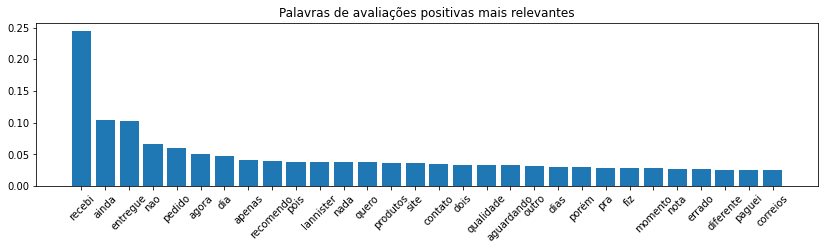

In [13]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords)
x = vectorizer.fit_transform(neg_text).todense()
x = np.mean(x, axis=0)

tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True)
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=45)
plt.title("Palavras de avaliações positivas mais relevantes")
plt.show()

#### Frases positivas

In [14]:
# Juntando todos os textos das colunas title e message
pos_text = list(pos_df['review_comment_title']) + list(pos_df['review_comment_message']) 

# Limpando valores Nan
pos_text = [x for x in pos_text if not pd.isnull(x)]

# Fazendo o stemming (removendo sufixos)
# for n in tqdm(range (len(pos_text))):
#     pos_text[n] = " ".join([stemmer.stem(p) for p in pos_text[n].lower().split()])

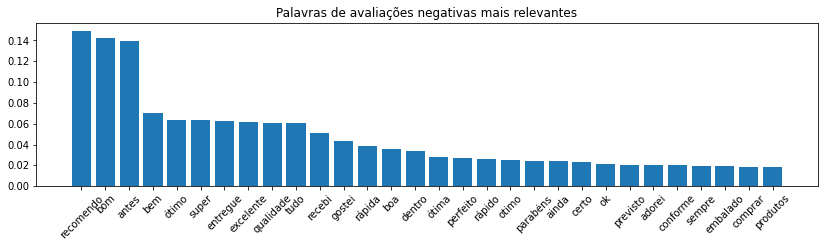

In [15]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords)
x = vectorizer.fit_transform(pos_text).todense()
x = np.mean(x, axis=0)

tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True)
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=45)
plt.title("Palavras de avaliações negativas mais relevantes")
plt.show()